In [22]:
import const
import os
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Step 1: Load files

In [2]:
img_l = cv2.imread(os.path.join(const.IMG_DIR, 'task_2\\left_0.png'))
img_r = cv2.imread(os.path.join(const.IMG_DIR, 'task_2\\right_0.png'))

cam_mtx_l = np.loadtxt(os.path.join(const.PAR_DIR, 'left_camera_intrinsics_cam_mtx.csv'))
dst_l = np.loadtxt(os.path.join(const.PAR_DIR, 'left_camera_intrinsics_dst.csv'))
cam_mtx_r = np.loadtxt(os.path.join(const.PAR_DIR, 'right_camera_intrinsics_cam_mtx.csv'))
dst_r = np.loadtxt(os.path.join(const.PAR_DIR, 'right_camera_intrinsics_dst.csv'))

## Step 2: Find 3D-2D point correspondences

In [3]:
crn_l = cv2.findChessboardCorners(img_l, const.GRID_SIZE)[1]
crn_r = cv2.findChessboardCorners(img_r, const.GRID_SIZE)[1]

In [4]:
obj_pt = np.concatenate((
        np.mgrid[0:const.GRID_SIZE[0], 0:const.GRID_SIZE[1]].T.reshape(-1, 2),
        np.zeros((const.GRID_SIZE[0] * const.GRID_SIZE[1], 1))
    ), axis=1).astype('float32')

In [5]:
crn_l.shape

(54, 1, 2)

## Step 3: Stereo Calibrate

In [6]:
params = cv2.stereoCalibrate(np.array([obj_pt]), np.array([crn_l]), np.array([crn_r]), cam_mtx_l, dst_l, cam_mtx_r, dst_r, (480, 640), flags=cv2.CALIB_FIX_INTRINSIC)

In [7]:
_, cam_mtx_l, dst_l, cam_mtx_r, dst_r, R, T, E, F = params

## Step 4: Verify calibration results

Undistort points using the camera and distortion matrices.

In [8]:
undist_crn_l = cv2.undistortPoints(crn_l, cam_mtx_l, dst_l)
undist_crn_r = cv2.undistortPoints(crn_r, cam_mtx_r, dst_r)

Generate matrices P1=[I|0] and P2=[R|t].

In [56]:
projection_l = np.concatenate((np.identity(3), np.zeros((3,1))), axis=1).astype('float32')
projection_r = np.concatenate((R, T), axis=1).astype('float32')

Triangulate the points.

In [57]:
points = cv2.triangulatePoints(projection_l, projection_r, undist_crn_l, undist_crn_r)
cartesian_points = points[:3] / points[3]

Plot the points.

In [61]:
def plot_camera(ax, R=np.identity(3), T=np.zeros((3,1))):
    # Constants assumed
    tanx, tany, f = 1, 1, 1
    
    points = np.asarray([
        (0,0,0),
        (-tanx, -tany, 1),
        (0,0,0),
        (-tanx, tany, 1),
        (0,0,0),
        (tanx, -tany, 1),
        (0,0,0),
        (tanx, tany, 1),
        (tanx, -tany, 1),
        (-tanx, -tany, 1),
        (-tanx, tany, 1),
        (tanx, tany, 1)
    ])
    
    points = np.dot(points, R).T + T
    
    ax.plot(*points, color='black')

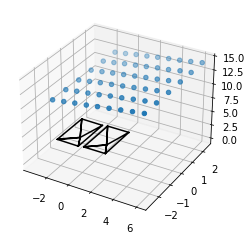

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*cartesian_points)
plot_camera(ax)
plot_camera(ax, R, T)

## Step 5: Undistort points

In [11]:
R_l, R_r, P_l, P_r, Q, roi_l, roi_r = cv2.stereoRectify(cam_mtx_l, dst_l, cam_mtx_r, dst_r, (480, 640), R, T)